In [8]:
from random import gauss
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
sys.path.insert(2,'..')
import functions
import xgboost as xgb
from sklearn import preprocessing
import annualized_rv as arv
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor # Random Forest model
from sklearn.ensemble import GradientBoostingRegressor # Gradient Boosting model
from sklearn.ensemble import AdaBoostRegressor # AdaBoost model
import sklearn.ensemble as ensemble

import tensorflow as tf
from tensorflow import keras

import DataProcess

In [2]:
# reads in the historic implied vol data calculated in the dailyaverageIV notebook

aaplHistIV = pd.read_pickle('historicImpliedVolData/aapl_mean_iv_2017_2022.pkl')
googHistIV = pd.read_pickle('historicImpliedVolData/goog_mean_iv_2017_2022.pkl')
msftHistIV = pd.read_pickle('historicImpliedVolData/msft_mean_iv_2017_2022.pkl')
ndxHistIV = pd.read_pickle('historicImpliedVolData/ndx_mean_iv_2017_2022.pkl')
spyHistIV = pd.read_pickle('historicImpliedVolData/spc_mean_iv_2017_2022.pkl')




In [3]:
def modelandeval(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    MSE,RMSE, MAE, R2 = DataProcess.evaluate_regression_metrics(y_test, y_pred)
    
    return RMSE, MAE, R2, MSE

In [9]:
X_train, X_test, y_train, y_test = DataProcess.preprocess_data(spyHistIV, 'SPY', seq_length=60, splits=5, window=21) #preprocess spy 
X_train_reshape = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
X_test_reshape = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])

In [10]:
def modelandeval(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    MSE,RMSE, MAE, R2 = DataProcess.evaluate_regression_metrics(y_test, y_pred)
    
    return RMSE, MAE, R2, MSE

Epoch 1/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1909 - val_loss: 1.3557
Epoch 2/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0621 - val_loss: 1.1764
Epoch 3/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0549 - val_loss: 1.0781
Epoch 4/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0490 - val_loss: 0.6888
Epoch 5/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0511 - val_loss: 0.9125
Epoch 6/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0606 - val_loss: 0.9992
Epoch 7/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0467 - val_loss: 0.9403
Epoch 8/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0437 - val_loss: 1.0038
Epoch 9/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0522 - val_loss: 0.8257
Epoch 10/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0465 - val_loss: 0.8950
Epoch 11/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0473 - val_loss: 0.9593
Epoch 12/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0

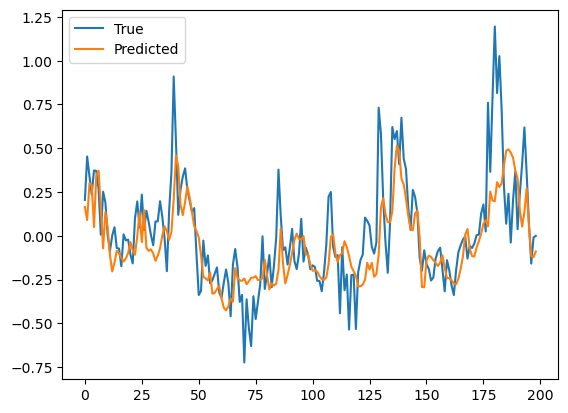

In [18]:
#LSTM Model
seq_length = 100

model = keras.models.Sequential([
    keras.layers.LSTM(seq_length, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.LSTM(seq_length),
    keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

# pass tensors instead of numpy arrays
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = map(lambda x: tf.convert_to_tensor(x, dtype=tf.float32), [X_train, y_train, X_test, y_test])
history = model.fit(X_train_tensor, y_train_tensor,validation_split=0.33, epochs=60, batch_size=16)
y_pred = model.predict(X_test_tensor)
y_test_tensor = np.array(y_test_tensor)  # Ensure y_test is a numpy array for consistency

DataProcess.evaluate_regression_metrics(y_test_tensor, y_pred)
DataProcess.plot(y_test_tensor, y_pred)

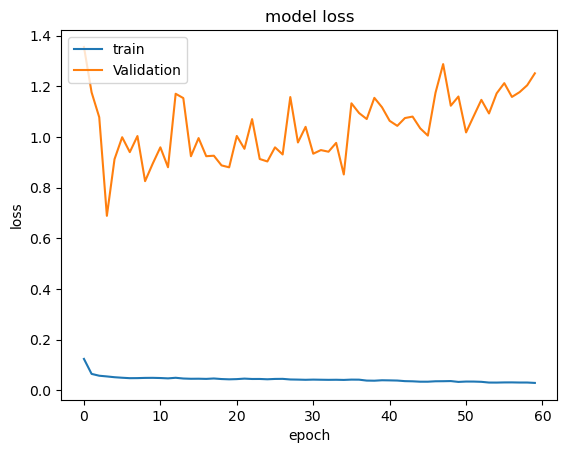

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()